In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment as expt
import utils.misc as mutil

reload(polc)
reload(expt)
reload(mutil);

## Simulation Parameters

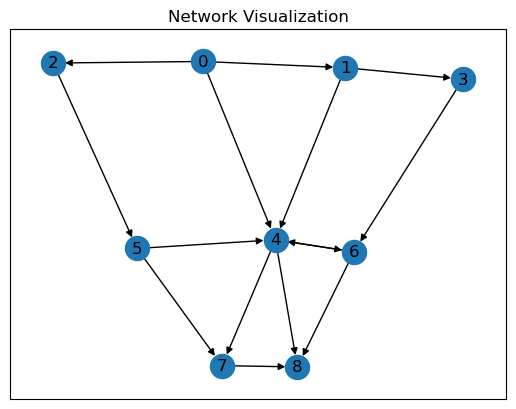

In [2]:
# simulation lengths
T_horizon = None # time horizon (to be set later)
T_horizon_list = 1000*np.arange(1,21)
N_runs = 5 # number of simulations

# noise and arrival rates
def random_uniform(size = []):
    return 2*np.random.uniform(size = size)-1
noise_distribution = random_uniform # np.random.standard_normal
noise_variance = 0.05 # sigma^2
arrival_rate   = 4 # lambda

# algorithm parameters
beta  = 4.5*noise_variance # exploration tuner (should theoretically be > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (should theoretically be T^{1/3}) (to be set later)
delta = None # exploration tuner (should theoretically be T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

# topology
N_nodes          = 9
source_node      = 0
destination_node = 8
edges_list       = [[0,1], [0,4], [0,2], [1,3], [1,4], [2,5], [3,6], [6,4], [4,6], [4,7], [5,4], [5,7], [6,8], [4,8], [7,8]]
node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

# edge properties
edge_capacities = np.array([4,2,2,2,2,2,2,1,1,1,1,1,2,5,2]) # max-flow = 8
true_edge_costs = np.array([2,5,1,1,2,1,1,1,1,1,1,3,3,1,1])/10

# pack parameters
simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_node, destination_node, 
                 noise_variance, noise_distribution,
                 arrival_rate, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

# visualize topology
mutil.visualize_network(edges_list, N_nodes)

## Static Policy

In [3]:
# get solution to static optimization problem
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)
total_stat_cost_per_time = stat_edge_rates@true_edge_costs
stat_costs = T_horizon_list*total_stat_cost_per_time

## DPOP Policy

In [4]:
# intialization
tran_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_dpop = np.zeros(T_horizon_list.shape)

# iterate over given T values
for jj in trange(T_horizon_list.shape[0]):
    ii = T_horizon_list.shape[0] - jj - 1

    # change policy parameters for this value of T
    simulation_params = expt.set_simulation_params(simulation_params, T_horizon_list[ii])

    # run experiment for this value of T
    queueing_network = expt.run_experiment(simulation_params, custom_seed = 13)
    
    # save cost and backlog values
    tran_cost_till_tt, backlog_cost_at_tt = expt.calculate_total_costs(queueing_network)
    tran_cost_till_T_dpop[ii] = tran_cost_till_tt[-1]
    backlog_cost_at_T_dpop[ii] = backlog_cost_at_tt[-1]

# calculate total cost
dpop_costs = tran_cost_till_T_dpop + backlog_cost_at_T_dpop

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:33<00:00,  7.68s/it]


## Results Summary

Arrival rate = 4, noise variance = 0.05
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.207 0.503 0.105 0.107 0.2   0.104 0.096 0.092 0.096 0.101 0.089 0.298
 0.298 0.106 0.097]


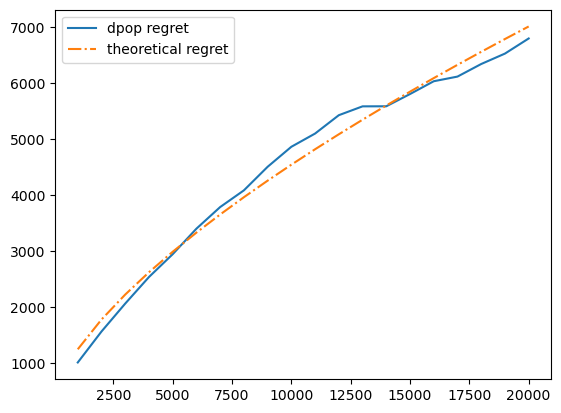

In [6]:
# save results
save_result = np.vstack((T_horizon_list, dpop_costs, stat_costs))
save_file = 'regret-lambda-' + str(arrival_rate).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
# np.save('./results/' + save_file, save_result)

# get theoretical fit
dpop_regret = dpop_costs - stat_costs
theoretical_dpop_regret = mutil.fit_regret_curve(T_horizon_list, dpop_regret)

# print summary
print('Arrival rate = ' + str(arrival_rate) + ', noise variance = ' + str(noise_variance))
print('True costs = ' + str(true_edge_costs))
print('Mean observed costs = ' + np.array2string(queueing_network.edge_cost_means[0,:], precision=3, suppress_small=True))

# plot regret
plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
plt.legend()
plt.show()